# Обработка видео
Классификация действий по видео


## Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [3]:
!pip install scikit-video==1.1.11

     |████████████████████████████████| 2.3 MB 8.1 MB/s 


In [4]:
import skvideo.io

## Загрузка и распаковка датасета KTH

In [5]:
!wget http://www.nada.kth.se/cvap/actions/walking.zip
!wget http://www.nada.kth.se/cvap/actions/jogging.zip
!wget http://www.nada.kth.se/cvap/actions/running.zip
!wget http://www.nada.kth.se/cvap/actions/boxing.zip
!wget http://www.nada.kth.se/cvap/actions/handwaving.zip
!wget http://www.nada.kth.se/cvap/actions/handclapping.zip 

--2022-03-27 17:03:08--  http://www.nada.kth.se/cvap/actions/walking.zip
Resolving www.nada.kth.se (www.nada.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.nada.kth.se (www.nada.kth.se)|130.237.28.41|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.nada.kth.se/cvap/actions/walking.zip [following]
--2022-03-27 17:03:08--  https://www.nada.kth.se/cvap/actions/walking.zip
Connecting to www.nada.kth.se (www.nada.kth.se)|130.237.28.41|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.csc.kth.se/cvap/actions/walking.zip [following]
--2022-03-27 17:03:09--  https://www.csc.kth.se/cvap/actions/walking.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242442411 (231M) [application/zip]
Saving to

In [6]:
!mkdir data

In [7]:
!unzip -q walking.zip -d ./data/walking
!unzip -q jogging.zip -d ./data/jogging
!unzip -q running.zip -d ./data/running
!unzip -q boxing.zip -d ./data/boxing
!unzip -q handwaving.zip -d ./data/handwaving
!unzip -q handclapping.zip -d ./data/handclapping

## Подготовка датасета для классификации

In [8]:
DATA_PATH = './data'

classes = os.listdir(DATA_PATH)

for cls in classes:
    cls_path = os.path.join(DATA_PATH, cls)
    print(f'class {cls}: {len(os.listdir(cls_path))} samples')

class walking: 100 samples
class boxing: 100 samples
class jogging: 100 samples
class handwaving: 100 samples
class handclapping: 99 samples
class running: 100 samples


In [9]:
test_size = 0.2
train_size = 1. - test_size
train_data = []
test_data = []

for i, cls in enumerate(classes):
    cls_path = os.path.join(DATA_PATH, cls)
    tmp = []
    for sample in os.listdir(cls_path):
        sample_path = os.path.join(cls_path, sample)
        tmp.append((sample_path, i))
    train_data += tmp[:int(len(tmp) * train_size)]
    test_data += tmp[int(len(tmp) * train_size):]

## Визуализация кадра из видео

videodata shape: (640, 120, 160, 3)


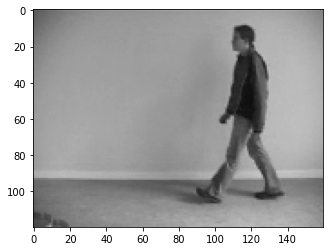

In [10]:
videodata = skvideo.io.vread(train_data[5][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
plt.imshow(videodata[50, ...])
plt.show()

In [11]:
import math
from tensorflow.keras.utils import Sequence


class KTHDataset(Sequence):
    
    def __init__(self, data, max_frames, shuffle=False, batch_size=1):
        self.data = data
        self.data_indices = list(range(len(data)))
        self.max_frames = max_frames
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.on_epoch_end()
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.data_indices)
        
    def _get_videodata(self, path):
        videodata = skvideo.io.vread(path)
        videodata = videodata.astype(np.float32) / 255.
        n_repeats = (self.max_frames + 1) // videodata.shape[0]
        last_frame = (self.max_frames + 1) - (videodata.shape[0] * n_repeats)
        # приведение массивов к форме (max_frames, height, width, n_channels)
        # видео с меньшим кол-вом кадров - повторяется до необходимого размера
        # видео с большим - обрезается
        videodata = np.append(
            np.repeat(videodata, n_repeats, axis=0), 
            videodata[:last_frame], 
            axis=0
        )
        # "движение"
        videodata = np.mean(
            videodata[1:, ...] - videodata[:-1, ...], 
            axis=3, 
            keepdims=True
        )
        return videodata
    
    def __getitem__(self, idx):
        batch_indices = self.data_indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X = []
        batch_y = []
        for i in batch_indices:
            path, label = self.data[i]
            videodata = self._get_videodata(path)
            batch_X.append(videodata)
            batch_y.append(label)
        return np.array(batch_X), np.array(batch_y)
    
    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

In [12]:
train = KTHDataset(train_data, max_frames=50, shuffle=True, batch_size=1)
test = KTHDataset(test_data, max_frames=50, shuffle=False, batch_size=1)

handclapping


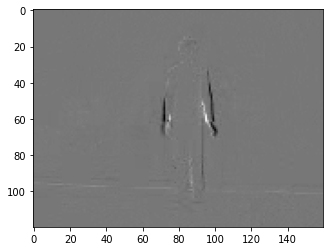

In [13]:
idx = np.random.randint(len(train))

batch_X, batch_y = train[idx]

plt.imshow(batch_X[0][-20, ..., 0], cmap='gray')
print(classes[batch_y[0]])
plt.show()

## Создание модели CNN

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])

## Подготовка к обучению

In [15]:
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

In [16]:
!mkdir models

In [17]:
checkpoint_filepath = './models/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [18]:
model.fit(train, validation_data=test, epochs=10, callbacks=[model_checkpoint_callback])

Epoch 1/10
479/479 [==============================] - 226s 469ms/step - loss: 1.7582 - val_loss: 1.2686
Epoch 2/10
479/479 [==============================] - 228s 475ms/step - loss: 1.1253 - val_loss: 0.6944
Epoch 3/10
479/479 [==============================] - 229s 477ms/step - loss: 0.7157 - val_loss: 0.4460
Epoch 4/10
479/479 [==============================] - 229s 478ms/step - loss: 0.5222 - val_loss: 0.4334
Epoch 5/10
479/479 [==============================] - 229s 479ms/step - loss: 0.4066 - val_loss: 0.2337
Epoch 6/10
479/479 [==============================] - 228s 477ms/step - loss: 0.3633 - val_loss: 0.7479
Epoch 7/10
479/479 [==============================] - 228s 477ms/step - loss: 0.2965 - val_loss: 0.2720
Epoch 8/10
479/479 [==============================] - 229s 478ms/step - loss: 0.2408 - val_loss: 0.2749
Epoch 9/10
479/479 [==============================] - 229s 477ms/step - loss: 0.3448 - val_loss: 0.3224
Epoch 10/10
479/479 [==============================] - 229s 478m

In [19]:
model.load_weights(checkpoint_filepath)

## Тестирование обученной модели

True class: handclapping
Predicted class: handclapping


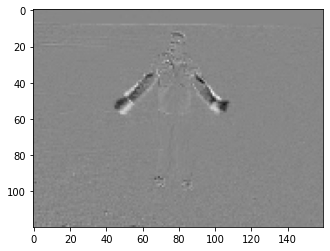

In [21]:
idx = np.random.randint(len(test))

batch_X, batch_y = test[idx]

plt.imshow(batch_X[0][20, ..., 0], cmap='gray')

out = model(batch_X)[0]
cls_pred = np.argmax(out.numpy())

print('True class:', classes[batch_y[0]])
print('Predicted class:', classes[cls_pred])
plt.show()